In [73]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import multiprocessing
from PIL import Image

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

# Data Visualization
from PIL import Image
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization of Paintings
from IPython.display import Image

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [74]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, scale=(1.0, 1.1), shear=0),      # zoom
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [75]:
batch_size = 128
data_dir = './drive/MyDrive/deep_learn/project/dataset'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
val_size = int(0.2 * len(image_datasets['train']))
train_size = len(image_datasets['train']) - val_size
train_set, val_set = random_split(image_datasets['train'], [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(image_datasets['test'], batch_size=batch_size)
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [76]:
def set_parameter_requires_grad(model, feature_extracting=False):
    # approach 1
    if feature_extracting:
        # frozen model
        model.requires_grad_(False)
    else:
        # fine-tuning
        model.requires_grad_(True)

In [77]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)


In [78]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=False, LoRA=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    weights = 'DEFAULT' if use_pretrained else None

    if model_name == "cnn_mobile net":
        model_ft = models.mobilenet_v3_small(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        rank, alpha = 4, 8
        if DoRA:
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=True)
        if LoRA:
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=False)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "cnn_resnet50":
        model_ft = models.resnet50(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_base 16":       # supervised visual transformer model - 86.6M params
        model_ft = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads[0].in_features
        model_ft.heads[0] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_dino v2":           # self-supervised visual transformer model - 91.5M params
        model_ft = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.linear_head.in_features
        model_ft.linear_head = nn.Linear(num_ftrs, num_classes)

    else:
        raise NotImplementedError

    return model_ft

In [79]:
opt_models = ["cnn_mobile net", "cnn_resnet50", "vit_base 16", "vit_dino v2"]
CNN_model_name = opt_models[0]
ViT_model_name = opt_models[3]
num_classes = len(class_names)
num_epochs = 15
# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = True
LoRA = False
DoRA = True

In [80]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    model = model.to(device)
    since = time.time()

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc.cpu())

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc.cpu())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [81]:
# plot the best model
def plot_test_results(hist):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')

    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

In [82]:
best_models = [CNN_model_name, ViT_model_name]
model_save_dir = './drive/MyDrive/deep_learn/project/models'
models_save_names = []
histories = []

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 130MB/s]


Params to learn:
	 classifier.0.A
	 classifier.0.B
	 classifier.0.m
	 classifier.3.weight
	 classifier.3.bias
Epoch 0/14
----------
train Loss: 0.7180 Acc: 0.4881
val Loss: 0.6770 Acc: 0.5536

Epoch 1/14
----------
train Loss: 0.7029 Acc: 0.4985
val Loss: 0.7027 Acc: 0.5476

Epoch 2/14
----------
train Loss: 0.6758 Acc: 0.5610
val Loss: 0.6531 Acc: 0.6131

Epoch 3/14
----------
train Loss: 0.6570 Acc: 0.5967
val Loss: 0.6655 Acc: 0.5833

Epoch 4/14
----------
train Loss: 0.6367 Acc: 0.6473
val Loss: 0.6401 Acc: 0.6071

Epoch 5/14
----------
train Loss: 0.6250 Acc: 0.6562
val Loss: 0.6213 Acc: 0.6726

Epoch 6/14
----------
train Loss: 0.6241 Acc: 0.6458
val Loss: 0.6263 Acc: 0.6548

Epoch 7/14
----------
train Loss: 0.6137 Acc: 0.6473
val Loss: 0.5905 Acc: 0.6845

Epoch 8/14
----------
train Loss: 0.6066 Acc: 0.6637
val Loss: 0.6112 Acc: 0.6905

Epoch 9/14
----------
train Loss: 0.5920 Acc: 0.6741
val Loss: 0.5946 Acc: 0.7440

Epoch 10/14
----------
train Loss: 0.5970 Acc: 0.6414
val Lo

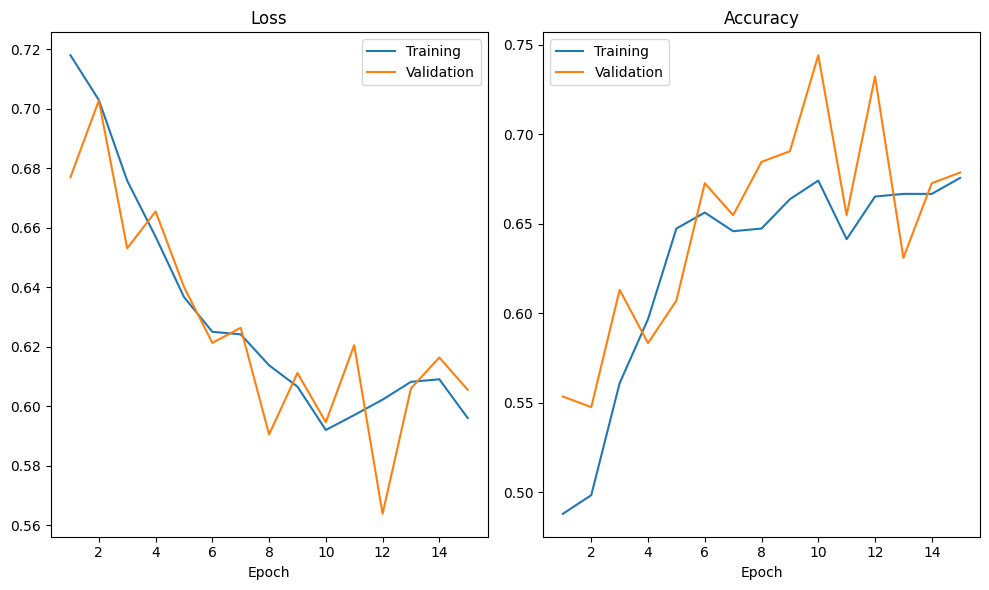

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 156MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_linear4_head.pth" to /root/.cache/torch/hub/che

Params to learn:
	 linear_head.weight
	 linear_head.bias
Epoch 0/14
----------
train Loss: 0.9794 Acc: 0.4866
val Loss: 0.8562 Acc: 0.5119

Epoch 1/14
----------
train Loss: 0.7141 Acc: 0.6205
val Loss: 0.5852 Acc: 0.7440

Epoch 2/14
----------
train Loss: 0.6031 Acc: 0.7158
val Loss: 0.6501 Acc: 0.7202

Epoch 3/14
----------
train Loss: 0.6554 Acc: 0.7054
val Loss: 0.7314 Acc: 0.7083

Epoch 4/14
----------
train Loss: 0.5777 Acc: 0.7336
val Loss: 0.6159 Acc: 0.7202

Epoch 5/14
----------
train Loss: 0.5304 Acc: 0.7693
val Loss: 0.6250 Acc: 0.7202

Epoch 6/14
----------
train Loss: 0.5318 Acc: 0.7545
val Loss: 0.5466 Acc: 0.7500

Epoch 7/14
----------
train Loss: 0.4972 Acc: 0.7619
val Loss: 0.5153 Acc: 0.7679

Epoch 8/14
----------
train Loss: 0.5323 Acc: 0.7530
val Loss: 0.4973 Acc: 0.7500

Epoch 9/14
----------
train Loss: 0.4573 Acc: 0.7961
val Loss: 0.5503 Acc: 0.7381

Epoch 10/14
----------
train Loss: 0.4488 Acc: 0.8051
val Loss: 0.5735 Acc: 0.6905

Epoch 11/14
----------
train 

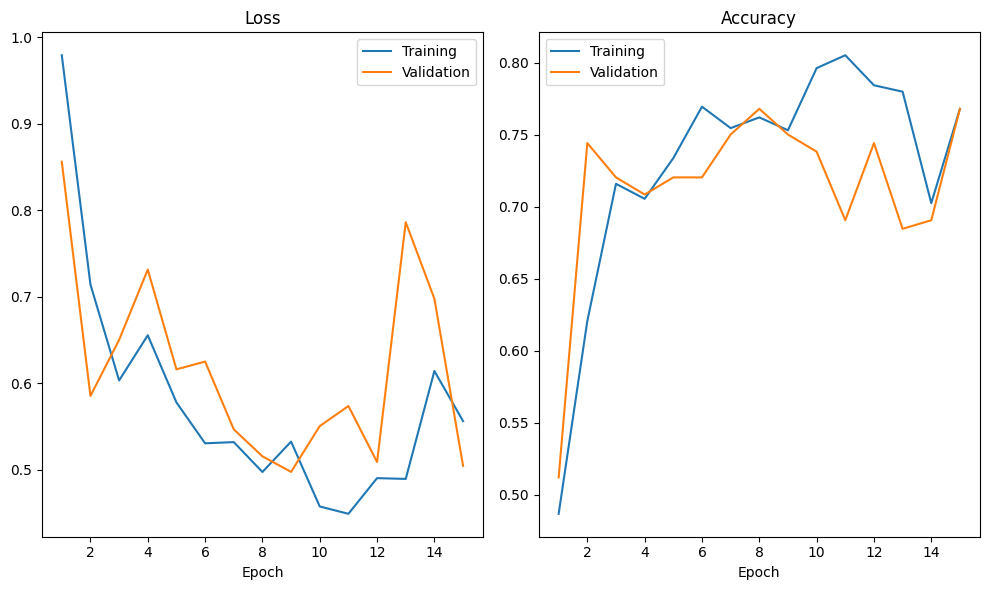

In [83]:
for model in best_models:

    # create save name for the model
    save_name = model + '_bs_' + str(batch_size) + '_ep_' + str(num_epochs)
    save_name = save_name + '_fe' if feature_extract else save_name + '_ft'
    save_name = save_name + '_DoRA' if DoRA else save_name + '_LoRA' if LoRA else save_name
    save_name += '.pth'
    models_save_names.append(save_name)


    # Initialize the model for this run
    if model == CNN_model_name:
        model_ft = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
    else:
        model_ft = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True)

    # Print the model we just instantiated
    # print(model_ft)

    model_ft = model_ft.to(device)

    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []  # override the initial list definition above
        for name, param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t", name)

    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, history = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

    # plot and save results
    histories.append(history)
    plot_test_results(history)

    # save model
    model_save_path = os.path.join(model_save_dir, save_name)
    torch.save(model_ft.state_dict(), model_save_path)

In [84]:
# load models
CNN_weights_path = os.path.join(model_save_dir, models_save_names[0])
CNN_best = initialize_model(best_models[0], num_classes, feature_extract, use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
CNN_best.load_state_dict(torch.load(CNN_weights_path, map_location=device))

ViT_weights_path = os.path.join(model_save_dir, models_save_names[1])
ViT_best = initialize_model(best_models[1], num_classes, feature_extract, use_pretrained=True)
ViT_best.load_state_dict(torch.load(ViT_weights_path, map_location=device))

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


<All keys matched successfully>

In [85]:
# testing function
def test_model(model, test_loader, criterion, optimizer, num_epochs=25):
    model = model.to(device)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_probs = []

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # classes probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            # class prediction
            _, preds = torch.max(outputs, 1)
            # add to history
            all_preds.append(preds.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    print('Test loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


    return epoch_loss, epoch_acc, all_preds, all_probs

##### PREDCITIONS ON TEST DATA ######

In [86]:
test_ds = image_datasets['test']
class_names_bin = test_ds.classes
label_to_str = {index: value for index, value in enumerate(class_names_bin)}
test_file_list = test_ds.imgs
# True classes
y_true = np.array(test_ds.targets)

In [87]:
# Make predictions for each of the two models (Evaluate on the test set)
CNN_test_loss, CNN_test_acc, CNN_preds, CNN_probs = test_model(CNN_best, dataloaders['test'], criterion, optimizer_ft, num_epochs=num_epochs)
ViT_test_loss, ViT_test_acc, ViT_preds, ViT_probs = test_model(ViT_best, dataloaders['test'], criterion, optimizer_ft, num_epochs=num_epochs)

Test loss: 0.4052 Acc: 0.8457
Test loss: 0.2422 Acc: 0.9202


In [88]:
y_pred_cnn = np.concatenate(CNN_preds)
y_pred_vit = np.concatenate(ViT_preds)

y_prob_cnn = np.concatenate(CNN_probs)
y_prob_vit = np.concatenate(ViT_probs)


print('CNN model, test set accuracy: {:5.2f}%'.format(100 * CNN_test_acc))
print('ViT model, test set accuracy: {:5.2f}%'.format(100 * ViT_test_acc))

CNN model, test set accuracy: 84.57%
ViT model, test set accuracy: 92.02%


In [89]:
# Define function to plot Confusion matrix depending on model
def plot_CM(model_name, data=test_ds):

    if model_name == "CNN":
        pred_labels = y_pred_cnn
    elif model_name == "ViT":
        pred_labels = y_pred_vit
    else:
        print("Provide either CNN or ViT as model_name.")

    acc_score = np.mean(pred_labels == y_true)
    # get the confusion plot
    cm = sklearn.metrics.confusion_matrix(y_true, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names_bin)
    return (disp)

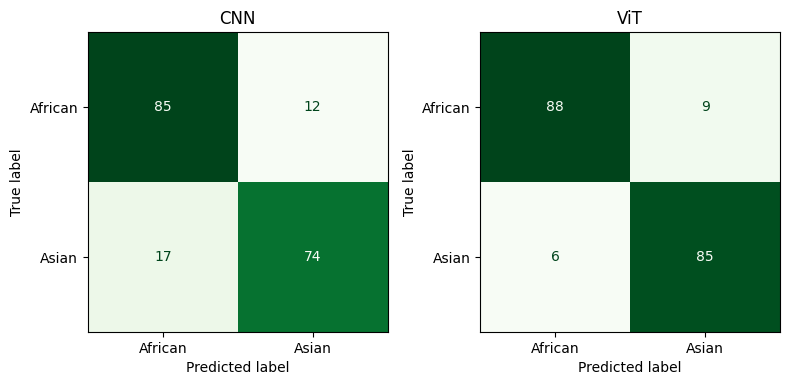

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_CM('CNN').plot(ax=ax[0], cmap="Greens", colorbar=False)
ax[0].set_title('CNN')
plot_CM('ViT').plot(ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title('ViT')
plt.tight_layout()
plt.show()

In [91]:
#### PLOTTING FUNCTION
# Define a function that plots 1 test set image and their corresponding prediction
def plotting_img_by_idx(test_file_list, idx_list, n_img=1, resize=False):

    idx_list = np.array(list(idx_list))
    # get n_img random elements from the list without replacement
    idx_list = idx_list[random.sample(range(0, len(idx_list)), n_img)]

    for i in range(len(idx_list)):
        idx = idx_list[i]
        if resize:      # optional - resize all images to shape (244,224, 3)
            img = Image.open(test_file_list[idx][0])
            img = img.resize((224, 224))
            img = np.array(img)
        else:
            img = plt.imread(test_file_list[idx][0])
        true_label = label_to_str[y_true[idx]]

        # cnn
        pred_label_cnn = label_to_str[y_pred_cnn[idx]]
        prob_cnn = np.max(y_prob_cnn[idx])

        # vit
        pred_label_vit = label_to_str[y_pred_vit[idx]]
        prob_vit = np.max(y_prob_vit[idx])


        # set title colors depending on prediction success
        if pred_label_cnn == true_label:
            color_cnn = 'green'
        else:
            color_cnn = 'red'

        # set title colors depending on prediction success
        if pred_label_vit == true_label:
            color_vit = 'green'
        else:
            color_vit = 'red'

        # format title labels
        cnn_text = "CNN: {} {:2.0f}% ({})".format(pred_label_cnn, 100 * prob_cnn, pred_label_cnn == true_label)
        vit_text = "ViT: {} {:2.0f}% ({})".format(pred_label_vit, 100 * prob_vit, pred_label_vit == true_label)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(cnn_text, color=color_cnn, x=0.5, y=1)
        plt.suptitle(vit_text, color=color_vit, x=0.5, y=0.99)
        plt.axis("off")
        plt.show()

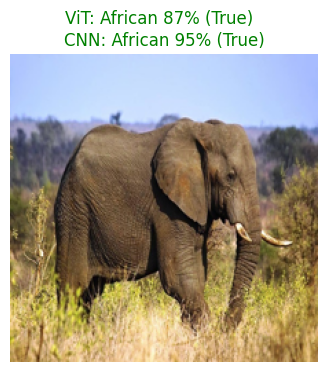

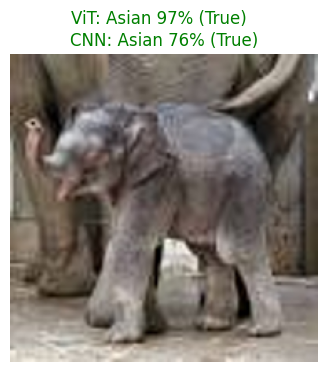

In [93]:
from PIL import Image
n_images = 4
idx_list = random.sample(range(len(y_true)), n_images)
plotting_img_by_idx(test_file_list, idx_list, n_img=2, resize=True)

In [94]:
false_cnn_idx = np.flatnonzero((y_true != y_pred_cnn))
false_vit_idx = np.flatnonzero((y_true != y_pred_vit))

# set intersection give us the commonly shared image id's of the two lists
false_both_idx = list(set(false_cnn_idx) & set(false_vit_idx))

# get idx list for cnn misses but vit hits
cnn_false_vit_hit = set(false_cnn_idx).difference(set(false_both_idx))

# Printing results
print(f'Total test set cases: {len(y_true)}')
print(
    "Incorrect classifications in {}: {}\nIncorrect classifications in {}: {}\nIncorrectly classified by both Models: {}".format(
        "CNN",
        len(false_cnn_idx),
        "ViT",
        len(false_vit_idx),
        len(false_both_idx)))
print(
    "That means:\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {} and\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {}.".format(
        100 * (1 - (len(false_both_idx) / len(false_cnn_idx))),
        len(cnn_false_vit_hit),
        "CNN", "ViT",
        100 * (1 - (len(false_both_idx) / len(false_vit_idx))),
        len(false_vit_idx) - len(false_both_idx),
        "ViT", "CNN"))

Total test set cases: 188
Incorrect classifications in CNN: 29
Incorrect classifications in ViT: 15
Incorrectly classified by both Models: 7
That means:
75.9% (n=22) of the CNN misclassifications were correctly classified by the ViT and
53.3% (n=8) of the ViT misclassifications were correctly classified by the CNN.


Need to add activation/attention maps. The implementation in torch is not straight forward as in tf so I faced some challenges with it...